In [75]:
%matplotlib inline
import Utilities.raster_utils as rast
import Utilities.stats_utils as stats
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats.kde import gaussian_kde
from sklearn import cluster as Kclust, metrics
from sklearn import preprocessing

from __future__ import absolute_import
from IPython.core.getipython import get_ipython
from IPython.core.magic import (Magics, magics_class,  cell_magic)
import sys
from StringIO import StringIO
from markdown import markdown
from IPython.core.display import HTML
 
@magics_class
class MarkdownMagics(Magics):
 
    @cell_magic
    def asmarkdown(self, line, cell):
        buffer = StringIO()
        stdout = sys.stdout
        sys.stdout = buffer
        try:
            exec(cell, locals(), self.shell.user_ns)
        except:
            sys.stdout = stdout
            raise
        sys.stdout = stdout
        return HTML("<p>{}</p>".format(markdown(buffer.getvalue(), extensions=['markdown.extensions.extra'])))
        return buffer.getvalue() + 'test'
 
get_ipython().register_magics(MarkdownMagics)


In [74]:
base_str = 'Imagery_Data/L8'

def multi_img_to_array(multi_image_list):
    ravel_list = map(np.ravel, multi_image_list)
    return np.array(ravel_list)

def normalize_(imgs):
    return preprocessing.normalize(imgs, norm='l2', axis=1)

#################
# Load the data #
#################

#Ground truth data
NLCD = rast.read_raster('Imagery_Data/NLCD_2011.tif')

#Get TOA reflectance for the red and NIR bands
GREEN = rast.transform_TOA(base_str, 3)
RED = rast.transform_TOA(base_str, 4)
NIR = rast.transform_TOA(base_str, 5)
SWIR = rast.transform_TOA(base_str, 6)
TIR = rast.transform_sat_brightness_temp(base_str, 11)

#Wide Dynamic Range Veg Index
WDRVI = rast.calc_normalized_diff(NIR, RED, alpha=0.2)
#Normalized Diff Water Index
NDWI = rast.calc_normalized_diff(GREEN, NIR, alpha=1.0)

NISI_ = rast.NISI(GREEN, SWIR, NIR, TIR)


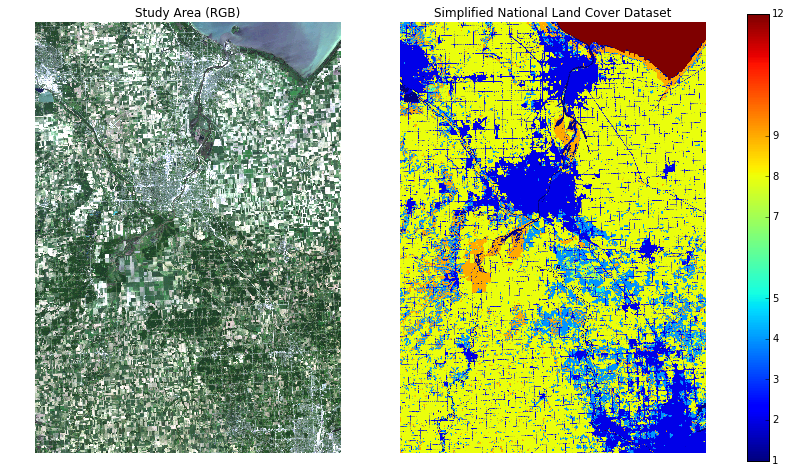

In [56]:
#######################################################
#From the NLCD FAQ: file:///Users/john/Downloads/land_use_land_cover_NLCD_mbr_3038831_01/land_use_land_cover%5Cnlcd_2011_faq.html
#
#The simplified land cover types are:
# - 1: Water
# - 2: Developed land
# - 3: Barren
# - 4: Forest
# - 5: Scrub
# - 7: Grassland
# - 8: Agricultural Land
# - 9: Wetland
# - 12: No Data (Lake Huron)
#######################################################

def group_NLCD(array):
    return (array / 10).astype(int)

simple_NLCD = group_NLCD(NLCD)

plt.figure(figsize = (15,10))
image = rast.get_multiband_array(base_str, bn=(4,3,2), enhance='stretch_histogram', gamma=1.25, percentile=95)
ax1 = plt.subplot(121)
ax1.imshow(image);
ax1.set_title('Study Area (RGB)');
ax1.set_axis_off()

ax2 = plt.subplot(122)
ax2.imshow(simple_NLCD, cmap='Set2');
ax2.set_title('Simplified National Land Cover Dataset');
ax2.set_axis_off()

#Add legend
plt.colorbar(plt.imshow(simple_NLCD), ax=[ax1, ax2], ticks=np.unique(simple_NLCD).tolist(), shrink=0.8);

#To do: Add discrete legend

### Build the Dataset

Looking at our study area, we can see a good mix of land cover types. Areas of Flint, Saginaw, and Bay City provide a good mix of developed land within the mostly agricultural area of mid-Michigan. For our modeling exercise, I will split the image in half vertically to give us spatially coherant test and training datasets.

To actually build the model, we need to take a sample from the training / test halves of the images. To do this in a way that:

* Takes the spatial structure of the data into account
* Ensures data is taken from across the whole image
* Is relativly random

we will use a sampling method known as two step sampling. The procedure is relativly straightforward:

1. Partition the image into regular grid cells
2. Randomly take `n` samples from each grid cell

See [here](http://www.lreis.ac.cn/upload/article/wjf_sampling%20review121015.pdf) for an overview of spatial sampling methods.


In [26]:
#Build the test and training datasets for our model
test = np.dstack((simple_NLCD,WDRVI, NDWI, NISI_))[:, :850]
train = np.dstack((simple_NLCD,WDRVI, NDWI, NISI_))[:,850:]

#NLCD value `128` is a no data value (Lake Huron far from the shore) removing from the training data
train_sample = np.array(stats.two_step_sample(train, 10000, (50,50)))
train_sample = np.delete(train_sample, np.where(train_sample[:,0]==12)[0], axis=0)
test_sample = np.array(stats.two_step_sample(test, 10000, (50,50)))


### Data Overview


Let's take a look at the distributions of the data for each of the variables we are using in our model:
* WDRVI: Wide Dynamic Range Vegetative Index
* NDWI: Normalized Difference Water Index
* NISI: Normalized Impervious Surface Index

Each of these is meant to capture a different feature of the landscape (Vegetation, Water, Impervious surfaces), so we should expect to see some seperation between the primary land cover types.

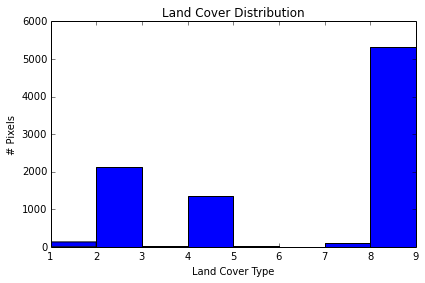

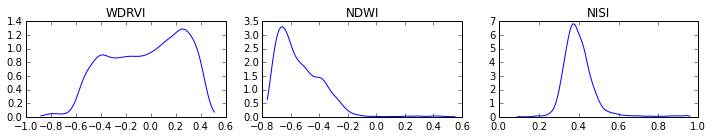

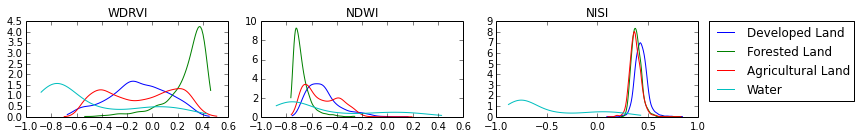

In [59]:
def subset(array, grp):
    return array[np.where(array[:,0]==grp)]

#Full Data Set Distribution
plt.hist(train_sample[:,0], 8);
plt.title('Land Cover Distribution')
plt.ylabel('# Pixels')
plt.xlabel('Land Cover Type')
plt.tight_layout()

#Data distribution for each feature
prob_dens = map(stats.density,[train_sample[:,1],train_sample[:,2],train_sample[:,3]])
plt.figure(figsize = (10,2))
ax1 = plt.subplot(131)
ax1.plot(prob_dens[0][0],prob_dens[0][1])
ax1.set_title('WDRVI')
ax2 = plt.subplot(132)
ax2.plot(prob_dens[1][0],prob_dens[1][1])
ax2.set_title('NDWI')
ax3 = plt.subplot(133)
ax3.plot(prob_dens[2][0],prob_dens[2][1])
ax3.set_title('NISI')
plt.tight_layout()

######################################
# Distributions by land cover type   #
######################################

sub_water = subset(train_sample, 1)
sub_developed = subset(train_sample, 2)
sub_forest = subset(train_sample, 4)
sub_ag = subset(train_sample, 8)

#set up the plot
plt.figure(figsize = (10,2))

#WDRVI curves
WDRVI_prob_dens = map(stats.density,[sub_developed[:,1],sub_forest[:,1],sub_ag[:,1],sub_water[:,1]])
ax1 = plt.subplot(131)
ax1.plot(WDRVI_prob_dens[0][0], WDRVI_prob_dens[0][1])
ax1.plot(WDRVI_prob_dens[1][0], WDRVI_prob_dens[1][1])
ax1.plot(WDRVI_prob_dens[2][0], WDRVI_prob_dens[2][1])
ax1.plot(WDRVI_prob_dens[3][0], WDRVI_prob_dens[3][1])
ax1.set_title('WDRVI')

#NDWI Curves
NDWI_prob_dens = map(stats.density,[sub_developed[:,2],sub_forest[:,2],sub_ag[:,2],sub_water[:,1]])
ax2 = plt.subplot(132)
ax2.plot(NDWI_prob_dens[0][0], NDWI_prob_dens[0][1])
ax2.plot(NDWI_prob_dens[1][0], NDWI_prob_dens[1][1])
ax2.plot(NDWI_prob_dens[2][0], NDWI_prob_dens[2][1])
ax2.plot(NDWI_prob_dens[3][0], NDWI_prob_dens[3][1])
ax2.set_title('NDWI')

#NISI Curves
NISI_prob_dens = map(stats.density,[sub_developed[:,3],sub_forest[:,3],sub_ag[:,3],sub_water[:,1]])
ax3 = plt.subplot(133)
ax3.plot(NISI_prob_dens[0][0], NISI_prob_dens[0][1], label='Developed Land')
ax3.plot(NISI_prob_dens[1][0], NISI_prob_dens[1][1], label='Forested Land')
ax3.plot(NISI_prob_dens[2][0], NISI_prob_dens[2][1], label='Agricultural Land')
ax3.plot(NISI_prob_dens[3][0], NISI_prob_dens[3][1], label='Water')
ax3.set_title('NISI')

ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

Looking at the breakout of each feature by the land cover type, we can see there is not a lot of seperation between the land cover types in NISI. WDRVI and NDWI are better, but not great. An interesting note: agricultural land has a bimodal distribution in both WDRVI and NDWI, possibly due to the presence of both planted and bare fields. In this area, winter wheat is a common crop- at this time of year it is already turning brown, increasing its reflectivity. 

## Predicting Land Cover

Now that we have a better understanding of the dataset, let's build a model. We will be using random forest, an ensamble model with good results on a wide range of problems. Essentially, random forest uses multiple subsets of the data to construct a series of decision trees, the results of which are averaged.

### Learn More
* [Scikit-Learn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [Basic overview](http://blog.yhat.com/posts/random-forests-in-python.html) of random forest
* [Detailed discussion](http://arxiv.org/pdf/1407.7502.pdf) of random forest 


In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

#Build a random forest model
rf_model = RandomForestClassifier(n_estimators=100, criterion="entropy",oob_score=True,max_features="sqrt",random_state=53478,min_samples_split=10)
rf_model.fit(train_sample[:,1:],train_sample[:,0])

#How well does the model perform? run it on the test data...
print 'Test Data Score: ', rf_model.score(test_sample[:,1:], test_sample[:,0])

#to do: Clean up the confusuon matrix output


Test Data Score:  0.678272222827


## Results

Running the model on our test data gives us `score: 0.68`. This is not too bad (see more [here](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.score) ), given the limited feature set used in the model. The real issue with this kind of measure is that it does not give us any understanding of how the model performed on each of the classes, or where the model had difficulty distinguishing between particular classes. For this, we need to look at a confusion matrix.

In [158]:
import pandas as pd

def pad_cell(x):
    while len(x)<4:
        x = x + ' '
    return x

y_pred = rf_model.predict(test_sample[:,1:])
cm = (confusion_matrix(test_sample[:,0], y_pred)).tolist()

#print a more readable confusion matirx
labels = [1,2,3,4,5,7,8,9]

print '          Predicted'
print 'Actual'
print ' '.join(map(pad_cell,[str(l) for l in ['         ']+labels]))
print ''
for l,r in zip(labels,range(len(cm))):
    print '    ',' '.join(map(pad_cell,[str(c) for c in [l]+cm[r]]))
print ' '
print "Producer's Accuracy (%)"
print '         ',' '.join(map(pad_cell,[str(el) for el in (np.diag(cm) / (np.sum(cm, axis=0)).astype(float) *100).astype(np.uint8)]))



          Predicted
Actual
          1    2    3    4    5    7    8    9   

     1    75   13   0    2    0    0    16   22  
     2    3    588  0    49   0    0    791  14  
     3    0    3    0    1    0    0    13   1   
     4    1    76   0    514  0    0    326  18  
     5    0    5    0    4    0    0    12   0   
     7    0    10   0    8    0    0    58   2   
     8    3    672  0    98   0    0    5015 35  
     9    4    75   0    397  0    0    225  42  
 
Producer's Accuracy (%)
          87   40   0    47   0    0    77   31  


Looking at the confusion matrix above, we can see some clear issues with our model. Agricultural land is the class with the highest accuracy (and the most pixels), giving us the average accuracy of 68%. None of the other classes come close to this level.

Developed land (class 2), the next largest category, is hard for our model to predict, with an accuracy of 40%. It is usually confused with agricultural land, and intrestingly, with wetlands and forest as well. 

The next step is for us to take a look at how the model performs spatially. While the overall accuracy and land cover type accuracy rates leave much to be desired, let's see how well our model can reproduce the landscape of our study area.


In [36]:
#prepare the test area of the image for prediction by the model
pred_image = np.copy(test[:,:,0])
_x,_y = np.where(~np.isnan(test[:,:,1]))
pred_image[_x,_y] = rf_model.predict(test[_x,_y,1:])

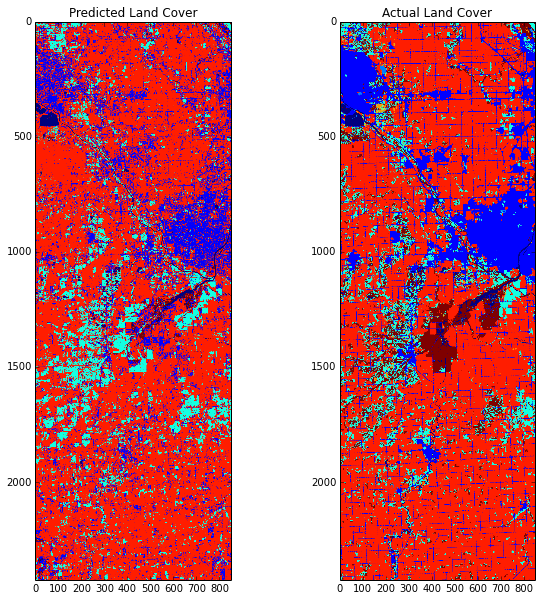

In [38]:
#plot the 1) predicted landcover 2) actual land cover

##
#To Do: set color map to the one used above, add legend
##

plt.figure(figsize = (10,10))
ax1 = plt.subplot(121)
ax1.imshow(pred_image)
ax1.set_title('Predicted Land Cover')
ax2 = plt.subplot(122)
ax2.imshow(test[:,:,0])
ax2.set_title('Actual Land Cover')